In [90]:
# Libraries
import torch
import pickle
from model import BertForTokenClassification
import utils.NERutils as nu

from transformers import AutoConfig, AutoTokenizer

from torch.utils.data import DataLoader
from tqdm import tqdm

# Define tokenizer
bert_model_name = "bert-base-multilingual-cased"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)

# Load data
train_path = "data/BIOtrain.parquet"
dev_path = "data/BIOdev.parquet"
test_path = "data/BIOtest.parquet"

# models_and_filters = ['Social Media','News','Web','Conversation','Wiki & Books','Legal','dannet']

# f1_scores = {model: dict() for model in models_and_filters}
FILTER = 'Legal'
model_type = 'Legal'

train_dataset = nu.NERdataset(dataset_path=train_path, tokenizer=bert_tokenizer, filter=FILTER)
dev_dataset = nu.NERdataset(dataset_path=dev_path, tokenizer=bert_tokenizer, filter=FILTER,tags=train_dataset.tags, index2tag=train_dataset.index2tag, tag2index=train_dataset.tag2index)
test_dataset = nu.NERdataset(dataset_path=test_path, tokenizer=bert_tokenizer, filter=FILTER,tags=train_dataset.tags, index2tag=train_dataset.index2tag, tag2index=train_dataset.tag2index)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
dev_loader = DataLoader(dev_dataset, batch_size=8, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=7, shuffle=False, num_workers=0)

# Set device
if torch.backends.mps.is_available():
    device = torch.device("cpu")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


# Config
bert_model_name = "bert-base-multilingual-cased"
bert_config = AutoConfig.from_pretrained(
    bert_model_name, 
    num_labels=len(train_dataset.tags), 
    id2label=train_dataset.index2tag, 
    label2id=train_dataset.tag2index
)

# initialise model
model = BertForTokenClassification.from_pretrained(bert_model_name, config=bert_config, tags=train_dataset.tags, verbose=True).to(device)

# Load model
model.load_state_dict(torch.load(f"Trained_models/source_domains/{model_type}_finetuned.pt", map_location=device))

# Evaluate model
preds, targets = nu.evaluate_model(model=model, dataloader=test_loader, device=device)

# Convert ids to tags
preds = [*map(train_dataset.index2tag.get, list(preds))]
golds = [*map(train_dataset.index2tag.get, list(targets))]

f1score = nu.getF1ScoreFromLists(golds=golds, preds=preds)
print(f"{f1score = }")
f1_scores[model_type][FILTER] = f1score



Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 35/35 [00:35<00:00,  1.03s/it]


f1score = 0.6984126984126984


In [82]:

with open("f1scores.pkl", "rb") as fp:
    f1_scores_load = pickle.load(fp)

with open("f1scores_training_data.pkl", "rb") as fp:
    f1_scores_training_data_load = pickle.load(fp)


Text(0.5, 1.0, 'Models tested on test data')

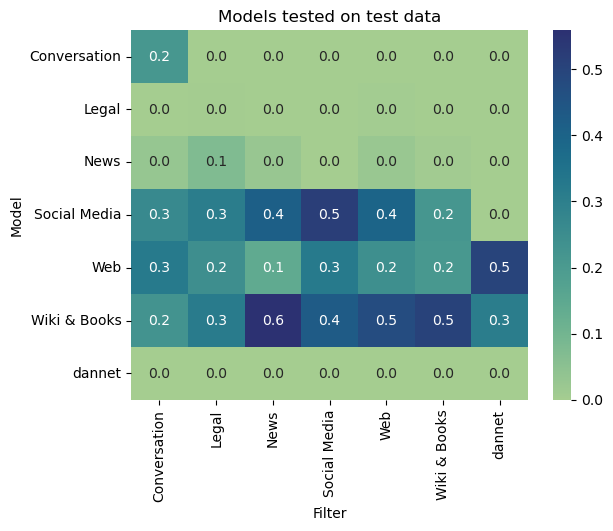

In [88]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
dfs = []

for model_type in models_and_filters:
    dfs.append(pd.DataFrame({'Model': [model_type]*7, 
                'Filter': f1_scores_load[model_type].keys(),
                'F1_scores': f1_scores_load[model_type].values()}))

f1_df = pd.concat(dfs).pivot(index="Model", columns="Filter", values="F1_scores")


sns.heatmap(f1_df,annot=True, fmt='.1f',cmap=sns.color_palette("crest", as_cmap=True))
plt.title("Models tested on test data")


Text(0.5, 1.0, 'Models tested on training data')

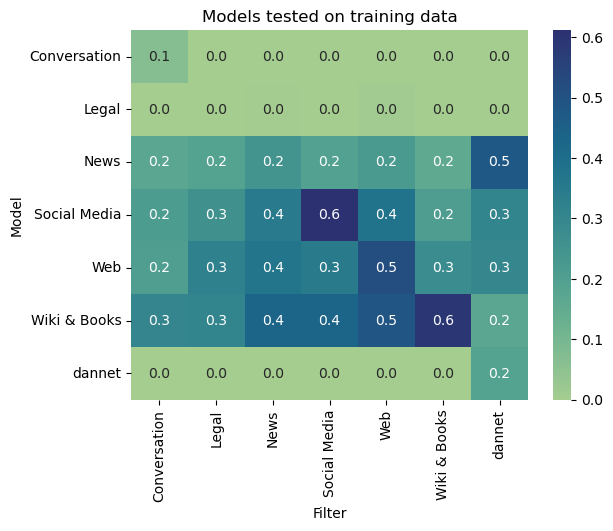

In [87]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
dfs = []

for model_type in models_and_filters:
    dfs.append(pd.DataFrame({'Model': [model_type]*7, 
                'Filter': f1_scores_training_data_load[model_type].keys(),
                'F1_scores': f1_scores_training_data_load[model_type].values()}))

f1_df = pd.concat(dfs).pivot(index="Model", columns="Filter", values="F1_scores")


sns.heatmap(f1_df,annot=True, fmt='.1f',cmap=sns.color_palette("crest", as_cmap=True))
plt.title("Models tested on training data")


In [81]:
train = nu.readDataset(train_path)
train.groupby("dagw_domain").count()[["text"]]



,text
dagw_domain,
Conversation,1020
Legal,1690
News,346
Social Media,439
Web,6661
Wiki & Books,1361
dannet,18
